This notebook preprocessed raw trisonica data to adjust the reference system to the EP one 

In [ ]:
from pathlib import Path
import numpy as np
from multiprocessing import Pool
import logging as log
from functools import partial
from wind_tools import rotate_ang
log.basicConfig(level=log.INFO)
# name_re = r"*_TRS_M00506_com3.raw"
in_dir = Path("2020_data/data_20200724_final_field_install/raw")
out_dir = Path("2020_data/data_20200724_final_field_install/preprocessed")
u, v, w = 0, 1, 2 #defing costants for accessing data

Utility function to rotate wind compoments, naive and slow approach but it works

In TRS deafult referecne system, the u xis is inverted compared to the EP one, fix this

In [ ]:
def process_m506(data):
    # fix TRS1 u ax by inverting it, due to different coordinate system between trisonica and EP
    data[:, u] = -1 * data[:, u]
    return data

M507 is mounted horizontally so there the need of a series of transformation to convert from the tilted and rotated m507 reference system to the standard EP one

Here you can find the analisys made to understand the steps needed [tinkercad model](https://www.tinkercad.com/things/cZxrXNQUGYp-exquisite-blad/edit)
![screen](m506_axis_rotation_sketch.png)

Steps required:
1. invert u axis
2. rotate the u by -45° on the anemometer horizontal plane (must be -45 because rotation func uses math angle notation)
3. remap axis   
    u = u  
    v = w   
    w = -v   
4. (optional) rotate taking into account the horizontal north offset (EP reference)

In [ ]:
def process_m507(data):
    # 1
    data[:, u] = -1 * data[:, u]
    # 2
    data[:, [u, v]] = rotate_ang(data[:, [u,v]], -45)
    # 3
    data[:, v] = data[:, w]
    data[:, w] = -1 * data[:, v]
    
    return data

trying to invert the v for m506 to then have the direction working

In [ ]:
def process_trs1_inv_v(data):
    data = process_m506(data)
    data[:, v] = -1 * data[:, v]
    return data

settings for each anemometer, the processor take in input an array where columns are u,v,w,t and returns a transformed array

In [ ]:
settings = {
    'm506': {
        'usecols': (10, 12, 14, 16),
        'name_re': r"*_TRS_M00506_com3.raw",
        'processor': process_m506
        },
    'm507': {
        'usecols': (10, 12, 14, 16),
        'name_re': r"*_TRS_M00507_com2.raw",
        'processor': process_m507  
    },
    'm506_v_inv': {
        'usecols': (10, 12, 14, 16),
        'name_re': r"*_TRS_M00506_com3.raw",
        'processor': process_trs1_inv_v,
        'name_suffix': '_inv_v'
    }
}


# wm = {'usecols': ()}

In [ ]:
def extract(usecols, processor, f, name_suffix=""):
    # log.info(f"opening {f}")
    out_name = out_dir / f"{f.name[:-4]}{name_suffix}.csv"
    if out_name.exists():
        log.info(f" exists, skipping {out_name}")
    else:
        data = np.genfromtxt(f, usecols=usecols, invalid_raise=False)
        data = processor(data)
        np.savetxt(out_name, data, header="u,v,w,t", delimiter=',', fmt='%2.2f')
        log.info(f"saved file {out_name}")

In [ ]:
def main():
    print("starting processing")
    if not out_dir.is_dir(): out_dir.mkdir(parents=True, exist_ok=True)
    with Pool() as p:
        for setg in settings.values():
            proc = partial(extract, setg["usecols"], setg["processor"], name_suffix=setg.get('name_suffix', ""))
            p.map(proc, in_dir.glob(setg["name_re"]))
    # for f in in_dir.glob(name_re):
    #     extract(f)

In [ ]:
main()

starting processing


INFO:root:saved file 2020_data/data_20200724_final_field_install/preprocessed/20200725-1330_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_20200724_final_field_install/preprocessed/20200726-2000_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_20200724_final_field_install/preprocessed/20200726-1900_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_20200724_final_field_install/preprocessed/20200727-0300_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_20200724_final_field_install/preprocessed/20200724-2300_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_20200724_final_field_install/preprocessed/20200728-0900_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_20200724_final_field_install/preprocessed/20200724-2030_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_20200724_final_field_install/preprocessed/20200725-1630_TRS_M00506_com3.csv
INFO:root:saved file 2020_data/data_20200724_final_field_install/preprocessed/20200728-0200_TRS_M00506_c

# OLD Testing -> can be discarded

In [ ]:
f = Path("2020_data/data_20200724_final_field_install/raw/20200724-1300_TRS_M00506_com3.raw")

In [ ]:
def printme(*args, **kwargs):
    print(args, kwargs)

In [ ]:
for setg in settings.values():
    
    proc = partial(printme, usecols=setg["usecols"], setg["processor"])
    proc(f)

((10, 12, 14, 16), <function process_trs1 at 0x7f0b080ece60>, PosixPath('2020_data/dati_test1_20200723/20200722-1734_TRS_M00506_com3.raw'))
((10, 12, 14, 16), <function process_m507 at 0x7f0b081287a0>, PosixPath('2020_data/dati_test1_20200723/20200722-1734_TRS_M00506_com3.raw'))


In [ ]:
# tested parsing using pandas but not working

In [ ]:
data = np.genfromtxt(f, usecols=(10, 12, 14, 16), invalid_raise=False)[:, [u,v, w]]
data = pd.DataFrame(data)
data.columns = ['u','v', 'w']

In [ ]:
data

,u,v,w
0,2.89,1.32,0.38
1,3.75,1.44,0.19
2,3.37,0.38,0.06
3,2.87,1.72,0.09
4,3.40,1.26,0.46
...,...,...,...
17995,1.91,1.00,-0.77
17996,2.92,1.17,-0.06
17997,3.43,1.85,0.32
17998,3.54,0.37,0.18


In [ ]:
def direction(wind):
    return np.rad2deg(np.arctan2(wind[:, v], wind[:, u]))

In [ ]:
def to_polar(data):
    x = data[:, u]
    y = data[:, v]
    return np.column_stack([np.sqrt(x**2+y**2), np.rad2deg(np.arctan2(y,x))])

In [ ]:
def wind_dir(wind):
    return np.rad2deg(np.pi - np.rad2deg((np.arctan2(wind[:, v], wind[:, u]))))

In [ ]:
wind_dir(data)

array([155.4515727 , 158.99321057, 173.56652312, ..., 151.65941401,
       174.03312328, 180.58762842])

In [ ]:
np.rad2deg(to_polar(data)[:, 1])

array([24.5484273 , 21.00678943,  6.43347688, ..., 28.34058599,
        5.96687672, -0.58762842])

In [ ]:
direction(data)

array([24.5484273 , 21.00678943,  6.43347688, ..., 28.34058599,
        5.96687672, -0.58762842])

In [ ]:
rot = rotate(data, 60, [u,v])

In [ ]:
(direction(rot) - direction(data)).mean()

-22.246770784939237

In [ ]:
rot = R.from_rotvec([0, np.pi/4,1])

In [ ]:
rot = to_polar(rotate(data, 90, [u,v]))

In [ ]:
org = to_polar(data)

In [ ]:
def wrap(polar_wind):
    polar_wind[:, 1] = polar_wind[:, 1] % 360
    return polar_wind

In [ ]:
to_polar(rotate(data, 90, [u,v]))

array([[   3.17718429,  -92.07172887],
       [   4.01697647,  -95.61336675],
       [   3.39135666, -110.1866793 ],
       ...,
       [   3.89710149,  -88.27957019],
       [   3.55928364, -110.65327946],
       [   3.90020512, -117.20778459]])

In [ ]:
rot = wrap(rot); rot

array([[  3.17718429, 267.92827113],
       [  4.01697647, 264.38663325],
       [  3.39135666, 249.8133207 ],
       ...,
       [  3.89710149, 271.72042981],
       [  3.55928364, 249.34672054],
       [  3.90020512, 242.79221541]])

In [ ]:
org = wrap(org); org

array([[  3.17718429,  24.5484273 ],
       [  4.01697647,  21.00678943],
       [  3.39135666,   6.43347688],
       ...,
       [  3.89710149,  28.34058599],
       [  3.55928364,   5.96687672],
       [  3.90020512, 359.41237158]])

In [ ]:
wrap(rot - org)

array([[ 0.00000000e+00,  2.43379844e+02],
       [ 0.00000000e+00,  2.43379844e+02],
       [-4.44089210e-16,  2.43379844e+02],
       ...,
       [ 0.00000000e+00,  2.43379844e+02],
       [-4.44089210e-16,  2.43379844e+02],
       [ 0.00000000e+00,  2.43379844e+02]])

In [ ]:
diff = wrap(rot - org).astype(np.int); diff

array([[  0, 243],
       [  0, 243],
       [  0, 243],
       ...,
       [  0, 243],
       [  0, 243],
       [  0, 243]])

In [ ]:
diff[:100]

array([[  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0, 243],
       [  0,

In [ ]:
def cart2pol(x, y):
    theta = np.arctan2(y,x)
    r = np.sqrt(x**2+y**2)
    return (theta, r)
def pol2cart(theta, r):
    x = np.cos(theta) * r
    y = np.sin(theta) * r
    return (x, y)

In [ ]:
def rotate_ang(df, ang):
    wind_dir, wind_speed = cart2pol(df.u, df.v)
    wind_dir += np.deg2rad(ang)
    return np.column_stack(pol2cart(wind_dir, wind_speed))

In [ ]:
np.column_stack(rotate_ang(data, 90))

array([[-1.32,  2.89],
       [-1.44,  3.75],
       [-0.38,  3.37],
       ...,
       [-1.85,  3.43],
       [-0.37,  3.54],
       [ 0.04,  3.9 ]])

In [ ]:
a = data.to_numpy()[:, [0,1]]

In [ ]:
rot = wrap(to_polar(rotate_ang(data, -90))); rot

array([[  3.17718429, 294.5484273 ],
       [  4.01697647, 291.00678943],
       [  3.39135666, 276.43347688],
       ...,
       [  3.89710149, 298.34058599],
       [  3.55928364, 275.96687672],
       [  3.90020512, 269.41237158]])

In [ ]:
org = wrap(org); org

array([[  3.17718429,  24.5484273 ],
       [  4.01697647,  21.00678943],
       [  3.39135666,   6.43347688],
       ...,
       [  3.89710149,  28.34058599],
       [  3.55928364,   5.96687672],
       [  3.90020512, 359.41237158]])

In [ ]:
wrap(rot - org)

array([[0.0000000e+00, 2.7000000e+02],
       [0.0000000e+00, 2.7000000e+02],
       [4.4408921e-16, 2.7000000e+02],
       ...,
       [0.0000000e+00, 2.7000000e+02],
       [0.0000000e+00, 2.7000000e+02],
       [0.0000000e+00, 2.7000000e+02]])

In [ ]:
diff = wrap(rot - org).astype(np.int); diff

array([[  0, 270],
       [  0, 270],
       [  0, 270],
       ...,
       [  0, 270],
       [  0, 270],
       [  0, 270]])

In [ ]:
import pandas as pd

In [ ]:
diff = pd.DataFrame(rot -org)

<AxesSubplot:>

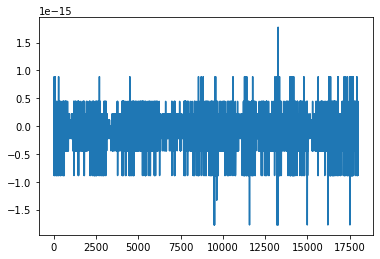

In [ ]:
diff[0].plot()

<AxesSubplot:>

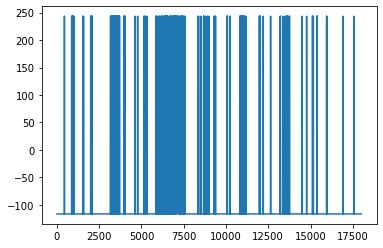

In [ ]:
diff[1].plot()

In [ ]:
diff.describe()

,0,1
count,1.800000e+04,18000.000000
mean,-1.190163e-16,-95.000156
std,2.456228e-16,85.534683
min,-1.776357e-15,-116.620156
25%,-2.220446e-16,-116.620156
50%,0.000000e+00,-116.620156
75%,0.000000e+00,-116.620156
max,1.776357e-15,243.379844


In [ ]:
data

array([[ 2.89,  1.32,  0.38],
       [ 3.75,  1.44,  0.19],
       [ 3.37,  0.38,  0.06],
       ...,
       [ 3.43,  1.85,  0.32],
       [ 3.54,  0.37,  0.18],
       [ 3.9 , -0.04,  0.05]])